<h1>1 PCA Analysis</h1>

Question 1.1

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
num_images = 10000
X = np.zeros((num_images, 4096, 3), dtype=np.float32)

image_dir = './resized_images' # related datas should be in this folder to run my code, otherwise change this directory
image_files = sorted(os.listdir(image_dir))    
    
for i, filename in enumerate(image_files[:num_images]):
    image_path = os.path.join(image_dir, filename)
    image = Image.open(image_path)
    
    if image.mode != 'RGB':
        image = image.convert('RGB')
        
    
    image_array = np.array(image, dtype=np.float32)
    
    flattened_image = image_array.reshape(-1, 3)
    X[i] = flattened_image
    
X_r = X[:, :, 0]  # Red 
X_g = X[:, :, 1]  # Green 
X_b = X[:, :, 2]  # Blue

print("Preprocessing completed. " + str(len(image_files)) + " images are preprocessed.")

Preprocessing completed. 10000 images are preprocessed.


In [4]:
def pca(data):
    # normalizing the data
    mean_vector = np.mean(data, axis=0)
    centered = data - mean_vector
    
    cov_matrix = np.cov(centered, rowvar=False) # covariance matrix

    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix) # eigenvalues and eigenvectors of cov matrix

    #sort them in desencing order
    indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[indices]
    sorted_eigenvectors = eigenvectors[:, indices]
    
    return sorted_eigenvectors, sorted_eigenvalues

#returns pva of first n eigenvectors
def pve(eigenvalues, n):
    total = np.sum(eigenvalues)
    pve = eigenvalues[:n]/total
    return pve


In [ ]:
# pca for each rgb
principal_components_red, eigenvalues_red= pca(X_r)
principal_components_green, eigenvalues_green = pca(X_g)
principal_components_blue, eigenvalues_blue = pca(X_b)

# first 10 pcs for each rgb
ten_pc_red = principal_components_red[:, :10]
ten_pc_green = principal_components_green[:, :10]
ten_pc_blue = principal_components_blue[:, :10]

#pve for first 10 eigenvectors
pve_red = pve(eigenvalues_red, 10)
pve_green = pve(eigenvalues_green, 10)
pve_blue = pve(eigenvalues_blue, 10)

print("PVE for first 10 components of red:", pve_red)
print("Sum of PVE's for first 10 pca of red:", np.sum(pve_red))
print("\n")
print("PVE for first 10 components of green:", pve_green)
print("Sum of PVE's for first 10 pca of green:", np.sum(pve_green))
print("\n")
print("PVE for first 10 components of blue:", pve_blue)
print("Sum of PVE's for first 10 pca of blue:", np.sum(pve_blue))
print("\n")

# min nums of components to achieve thresholds accuracy
def min_components_pve(eigenvalues, threshold=0.7):
    n = 1
    pve_val = 0
    while pve_val < threshold:
        pve_val = np.sum(pve(eigenvalues,n))
        if pve_val < threshold:
            n += 1
    return n
    
min_components_red = min_components_pve(eigenvalues_red)
min_components_green = min_components_pve(eigenvalues_green)
min_components_blue = min_components_pve(eigenvalues_blue)

print("Min number of components for to hit at least 70% PVE for red:", min_components_red)
print("Min number of components for to hit at least 70% PVE for green:", min_components_green)
print("Min number of components for to hit at least 70% PVE for blue:", min_components_blue)

PVE for first 10 components of red: [0.28929081 0.09373798 0.06788795 0.05859219 0.05419499 0.04384446
 0.02887794 0.02049209 0.01681582 0.01630701]
Sum of PVE's for first 10 pca of red: 0.6900412482040855


PVE for first 10 components of green: [0.32041101 0.08559319 0.08177433 0.05796603 0.04110711 0.03958217
 0.02568433 0.01855605 0.01663551 0.01604563]
Sum of PVE's for first 10 pca of green: 0.70335535380908


PVE for first 10 components of blue: [0.34357938 0.08854058 0.08477065 0.05722818 0.03805416 0.03354398
 0.02486367 0.01717688 0.01624892 0.01553017]
Sum of PVE's for first 10 pca of blue: 0.71953657404184


Min number of components for to hit at least 70% PVE for red: 11
Min number of components for to hit at least 70% PVE for green: 10
Min number of components for to hit at least 70% PVE for blue: 9


Question 1.2 

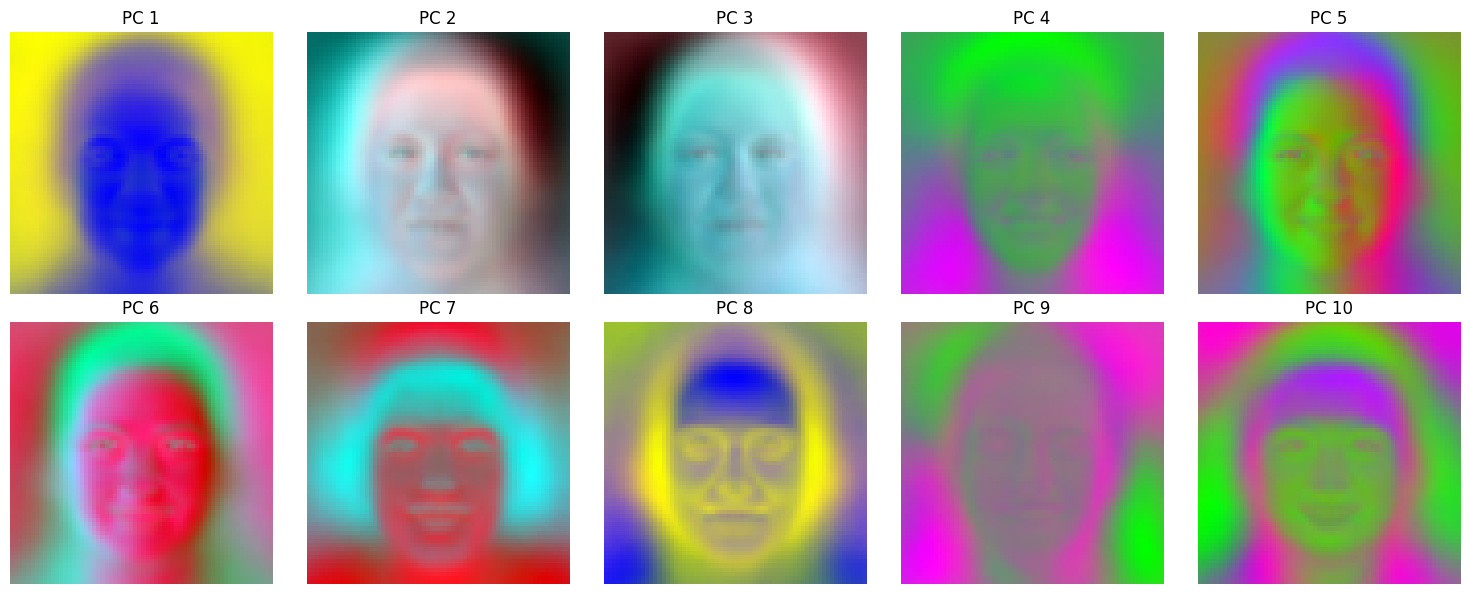

In [6]:
# reshaping and normalizing first 10 principal component to visualize
def rearrange(components, num_components=10):
    reshaped = [components[:, i].reshape(64, 64) for i in range(num_components)]
    normalized = [(comp - np.min(comp)) / (np.max(comp) - np.min(comp)) for comp in reshaped]
    return normalized

red = rearrange(principal_components_red)
green = rearrange(principal_components_green)
blue = rearrange(principal_components_blue)

# stacking corresponding components into RGB images to visualize properly
rgb_images = [np.stack((red[i], green[i], blue[i]), axis=-1) for i in range(10)]

# visualizing
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(rgb_images[i])
    ax.axis('off')
    ax.set_title(f"PC {i+1}")

plt.tight_layout()
plt.show()


Question 1.3

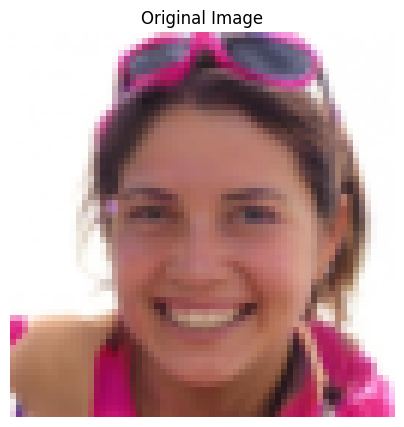

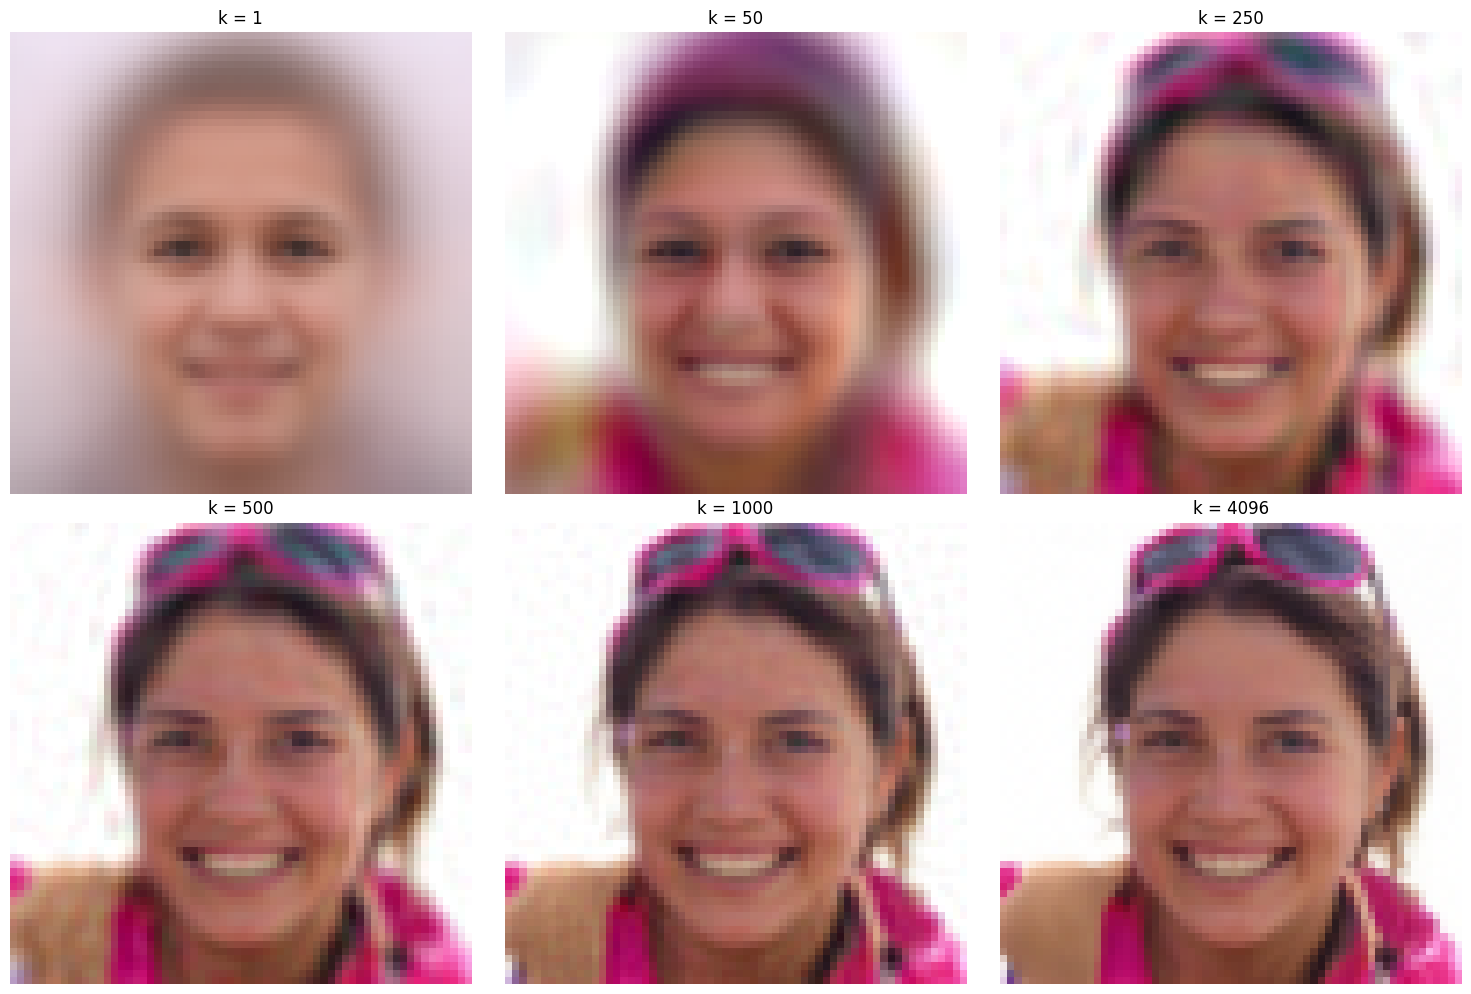

In [7]:
def reconstruct(image, mean_vector, eigenvectors, k):
    image_centered = image - mean_vector
    projected = np.dot(image_centered, eigenvectors[:, :k])
    reconstructed = np.dot(projected, eigenvectors[:, :k].T)
    reconstructed += mean_vector
    return reconstructed

#first image from the dataset
first_red = X_r[0]
first_green = X_g[0]
first_blue = X_b[0]

# mean vectors
mean_red = np.mean(X_r, axis=0)
mean_green = np.mean(X_g, axis=0)
mean_blue = np.mean(X_b, axis=0)

all_k = [1, 50, 250, 500, 1000, 4096]
reconstructed_images = []

for k in all_k:
    red_reconstructed = reconstruct(first_red, mean_red, principal_components_red, k)
    green_reconstructed = reconstruct(first_green, mean_green, principal_components_green, k)
    blue_reconstructed = reconstruct(first_blue, mean_blue, principal_components_blue, k)

    # stacking the rbg parts to visualize
    rgb_image = np.stack(
        (
            red_reconstructed.reshape(64, 64),
            green_reconstructed.reshape(64, 64),
            blue_reconstructed.reshape(64, 64),
        ),
        axis=-1,
    )
    reconstructed_images.append(rgb_image)

    
# visualizing 
#display the original photo
plt.figure(figsize=(5, 5))
original_image = np.stack(
    (
        first_red.reshape(64, 64),
        first_green.reshape(64, 64),
        first_blue.reshape(64, 64),
    ),
    axis=-1,
)
plt.imshow(np.clip(original_image, 0, 255) / 255.0) 
plt.axis('off')
plt.title("Original Image")
plt.show()


#display constructed photos
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(np.clip(reconstructed_images[i], 0, 255) / 255.0) 
    ax.axis('off')
    ax.set_title(f"k = {all_k[i]}")

plt.tight_layout()
plt.show()


